# Basic example

This example demonstrates some of the core functionality and export features provided by rabpro.

Note: you will need to download HydroBasins to run this demo. See [this notebook](https://github.com/VeinsOfTheEarth/rabpro/blob/main/docs/source/examples/notebooks/downloading_data.ipynb) for download instructions.

In [1]:
from matplotlib import pyplot as plt

import rabpro

First, we need to specify a point for which we'd like a watershed delineated.

In [2]:
coords = (44.9331, -69.4996)

Now we can initialize the profiler. The rabpro profiler is the main entry point into the package - it provides wrapper funcitons for most of the rabpro's core functionality.

Note that we can optionally specify a drainage area (`da`) or set `force_merit` to `True`, to ensure that we use MERIT data rather than HydroBasins to perform basin delineation.

In [3]:
rpo = rabpro.profiler(coords, name='basic_test')

https://raw.githubusercontent.com/VeinsOfTheEarth/rabpro/main/Data/gee_datasets.json download error. Place manually into D:\merit_data\Data\gee_datasets.json


rabpro can now compute the watershed for this point. Since we are not providing a pre-known drainage area to the profiler or specifying `force_merit=True`, rabpro will use HydroBasins to delineate the watershed. Delineation may take a minute or two as rabpro has to identify the correct level-12 HydroBasins shapefile and load it into memory (these files are >100MB).

In [4]:
%%capture
rpo.delineate_basin()

The basin geometry is stored in a GeoPandas GeoDataFrame, and can be accessed through the `rpo` object.

<Axes: >

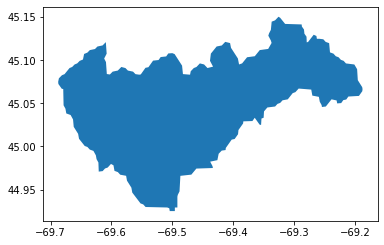

In [5]:
rpo.watershed.plot()

Next, we try to compute the river elevation profile. This will fail because we have not yet downloaded MERIT data.

In [6]:
%%capture
rpo.elev_profile(dist_to_walk_km=5)

If you'd like to complete this task, you will need to download the MERIT tile `n30w150`.

In [7]:
# we can use rabpro.utils.coords_to_merit_tile to identify the correct tile name
rabpro.utils.coords_to_merit_tile(coords[1], coords[0])

'n30w90'

Detailed instructions, including how to get a username and password for MERIT-Hydro downloads, are [here](https://github.com/VeinsOfTheEarth/rabpro/blob/main/docs/source/examples/notebooks/downloading_data.ipynb). Note that the MERIT tile will consume ~1.6 GB of space when unzipped.

`download_merit_hydro()` will automatically rebuild virtual rasters, which are how rabpro interacts with the individual geotiffs, after downloading a tile.

```python
from rabpro import data_utils
data_utils.download_merit_hydro('n30w90', username=your_merit_username, password=your_merit_password)
```

Now we can try again:

Extracting flowpath from DEM...


Text(0, 0.5, 'Elevation')

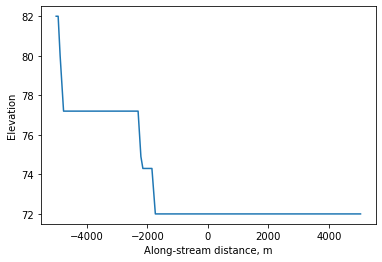

In [8]:
rpo.elev_profile(dist_to_walk_km=5)
plt.plot(rpo.flowline['Distance (m)'], rpo.flowline['Elevation (m)'])
plt.xlabel('Along-stream distance, m')
plt.ylabel('Elevation')

The along-stream distance is with respect to the provided coordinate. You can use the `rpo.flowline` GeoDataFrame to compute slopes.

You can export the `watershed` GeoDataFrame and/or the `flowline` GeoDataFrame using the `.export()` method.

In [9]:
%%capture
rpo.paths
rpo.export("all")

Once the subbasins are delinated, rabpro can use Google Earth Engine (GEE) to compute statistics for each subbasin. Using Google Earth Engine reduces the need to store large datasets locally, and speeds up computation by using GEE's parallel distributed computing capabilities.

Note: In order to use rabpro for basin statistics, you'll need to sign up for a GEE account. See rabpro's documentation for more information.

Before we compute basin statistics, we'll need to "build" our vector asset and upload it to GEE. This can be done either (1) manually through the GEE code editor, but you must first export as a shapefile, or (2) via `rabpro` automation. This automation requires that you have a writeable Google Cloud Platform (GCP) bucket and that you are authenticated via the command-line to call the `gsutil` and `earthengine` programs. These programs enable sending files to GCP and onward to GEE respectively.

For now, you can skip this step as we've uploaded a demonstration file as a public asset. However, for instructions on uploading your shapefile as a GEE asset, see [this page](https://developers.google.com/earth-engine/cloud/assets#uploading-assets).

```python
gcp_bucket = "your_gcp_bucket"
gee_user = "your_gee_username"
zip_path = rabpro.utils.build_gee_vector_asset(rpo.watershed, "rpo_basic.zip")
your_gee_asset = rabpro.utils.upload_gee_vector_asset(
    zip_path, gee_user, gcp_bucket, gcp_folder="rabpro"
)
```

In [11]:
import ee
ee.Initialize()

# Specify which statistics to calculate for the JRC/GSW1_4/GlobalSurfaceWater dataset's occurrence band
statlist = ['min']
data = rabpro.basin_stats.Dataset("JRC/GSW1_4/GlobalSurfaceWater", "occurrence", stats=statlist)

d, t = rpo.basin_stats([data], gee_feature_path="users/jstacompute/rpo_basic", folder="rabpro test")

Submitting basin stats task to GEE for JRC/GSW1_4/GlobalSurfaceWater...


The output data will be placed in the `rabpro test` folder in your Google Drive if it already exists. If not, GEE will create a new `rabpro test` folder at the root level of your Drive.

`basin_stats` returns a url to the resulting csv data which can be read directly with `pandas`:

In [12]:
print(d)
rabpro.basin_stats.fetch_gee(d, prepend_list=["basic"]).head()

['https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/tables/54699a14f7de869132ae860e0ec897b6-2228eb5923743f5c93511c0327985ddb:getFeatures']


,basic_system:index,basic_mean,basic_min
0,0_00000000000000000000,83.323821,0
